In [78]:
import numpy as np

import matplotlib.pyplot as plt

In [121]:
import numpy as np
import cvxopt
from cvxopt import matrix, solvers
import pandas as pd

rho = 1.
a = 0.25
b = 1

def gaussian(x, y, gamma = 0.5):
    return np.exp(-gamma * np.linalg.norm((x - y)))

def kernel(x, y):
    res = np.dot(x.T,y)
    return res

def kernel_matrix(X, kernel, **kwargs):
    n = X.shape[0]
    K = np.zeros((n, n))
    for i in range(n):
        if (i % 500 == 0):
            print(i)
        for j in range(n):
            K[i, j] = kernel(X[i], X[j], **kwargs)
    return K



def transform_dual(K,y,  C=300):
    # Here, we keep lambda as the variable. We need to make A bigger to account for the 2 inequalities on lambda
    n = K.shape[0]
    Q = matrix(np.diag(y)) * K * matrix(np.diag(y))
    p = - np.ones(n)
    G = np.zeros((2 * n, n))
    h = np.zeros(2 * n)
    G[:n, :n] = np.eye(n)
    G[n:2 * n, :n] = -np.eye(n)
    h[:n] = C * np.ones(n)
    return matrix(Q), matrix(p), matrix(G), matrix(h)


# def transform_dual2(X,y,C=.5):
#     # Here, we keep lambda as the variable. We need to make A bigger to account for the 2 inequalities on lambda
#     n = X.shape[0]
#     X_m = matrix(X.values)
#     P = X_m * X_m.T
#     q = - y * np.ones(n)
#     G = np.zeros((2 * n, n))
#     h = np.zeros(2 * n)
#     G[:n, :] = matrix(np.diag(y))
#     G[n:2 * n, :] = matrix(-np.diag(y))
#     h[:n] = C * np.ones(n)
#     return matrix(P), matrix(q), matrix(G), matrix(h)

# Computation of SVM
# Output : alpha.T * Diag(y)

def svm(K, y: object, C: object = 300) -> object:
    Q, p, G, h = transform_dual(K, y, C)
    print(type(Q))
    w_sol = solvers.qp(Q, p, G, h)
    print(w_sol)
    return np.dot(w_sol['x'].T, np.diag(y))


def pred(w, x, X):
    
    ker = np.array([kernel(x, X[i,:]) for i in range(X.shape[0])])
    return np.sign(np.dot(w,ker))

def predict(w,X_test,X_train):
    y_pred = np.ones(X_test.shape[0])
    for i in range(X_test.shape[0]):
        y_pred[i] = pred(w,X_test[i,:],X_train)
        
    return y_pred

def onevsallSVM(X, y, C=300):
    models = {}
    for cls in np.unique(y):
        X_train = X.copy()
        y_train = pd.Series([-1 if yval == cls else 1 for yval in y])
        models[cls] = svm(X_train, y_train, C=C)
    return models


def predict_onevsall(models, x, X, y):
    cls, margin = 0, 0
    ker = np.array([kernel(x, X[i]) for i in range(X.shape[0])])
    for i, m in models.items():
        a = np.dot(m, ker)
        if np.abs(a) > margin and a > 0:
            cls, margin = i, np.abs(a)
    return cls


def onevsoneSVM(X, y, C=300):
    for class1 in np.unique(y):
        for class2 in np.unique(y):
            if class1 != class2:
                X_train = pd.concat((X.loc[y == class1], X.loc[y == class2]))
                y_train = pd.concat((y.loc[y == class1]), y.loc(y == class2))


def error_rate(ypred, ytrue):
    return np.mean(1 * (ypred != ytrue))

In [89]:
G1 = np.random.normal(-1,0.5, (2,50))
G2 = np.random.normal(1,0.5, (2,50))

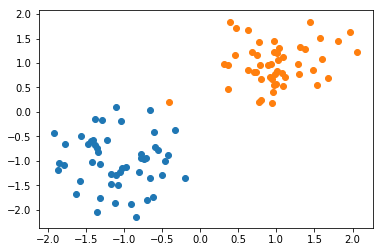

In [90]:
plt.scatter(G1[0],G1[1])
plt.scatter(G2[0],G2[1])

plt.show()

In [91]:
G = np.zeros((2,100))
G[:,:50] = G1
G[:,50:] = G2

label = np.ones(100)
label[:50] = -np.ones(50)

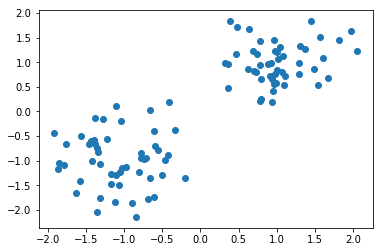

In [92]:
G.shape
plt.scatter(G[0],G[1])
plt.show()

G = G.T

In [93]:
K = np.dot(G,G.T)
K.shape

(100, 100)

In [126]:
w = svm(K,label,C = 0.5)

<class 'cvxopt.base.matrix'>
     pcost       dcost       gap    pres   dres
 0: -3.7500e+01 -8.7500e+01  3e+02  3e+00  2e-16
 1: -3.0634e+01 -6.6115e+01  4e+01  2e-16  4e-16
 2: -3.5104e+01 -3.7884e+01  3e+00  2e-16  1e-16
 3: -3.7468e+01 -3.7504e+01  4e-02  1e-16  1e-16
 4: -3.7500e+01 -3.7500e+01  4e-04  1e-16  2e-16
 5: -3.7500e+01 -3.7500e+01  4e-06  1e-16  2e-16
Optimal solution found.
{'y': <0x1 matrix, tc='d'>, 'dual slack': 8.523759513539297e-09, 'dual objective': -37.50000042618818, 'primal objective': -37.49999680167382, 'z': <200x1 matrix, tc='d'>, 'primal slack': 6.396651955253327e-08, 'dual infeasibility': 2.220446049250313e-16, 's': <200x1 matrix, tc='d'>, 'gap': 3.6245143624751922e-06, 'status': 'optimal', 'relative gap': 9.665372457614214e-08, 'iterations': 5, 'primal infeasibility': 1.1102230246251565e-16, 'x': <100x1 matrix, tc='d'>}


In [127]:
G1t = np.random.normal(-1,0.5, (2,1000))
G2t = np.random.normal(1,0.5, (2,1000))

In [128]:
np.sum(predict(w,G2t.T,G))

998.0

In [72]:
kernel(np.array([0.5,0.5]),G.T[0,:])

-0.36344130867905428

In [77]:
G.shape

(2, 100)

In [124]:
K = kernel_matrix(G,gaussian, gamma = 0.9)

0


In [125]:
K

array([[ 1.        ,  0.54088418,  0.9076444 , ...,  0.12371299,
         0.04506086,  0.06716695],
       [ 0.54088418,  1.        ,  0.55466006, ...,  0.09626969,
         0.03146968,  0.05687589],
       [ 0.9076444 ,  0.55466006,  1.        , ...,  0.13368733,
         0.0478682 ,  0.07307923],
       ..., 
       [ 0.12371299,  0.09626969,  0.13368733, ...,  1.        ,
         0.30095985,  0.50778713],
       [ 0.04506086,  0.03146968,  0.0478682 , ...,  0.30095985,
         1.        ,  0.31276261],
       [ 0.06716695,  0.05687589,  0.07307923, ...,  0.50778713,
         0.31276261,  1.        ]])